In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/archive.zip", 'r')
zip_ref.extractall("/dataset")
zip_ref.close()

In [ ]:
import os

data_dir = '/dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
file_names = os.listdir(data_dir)

# Print the file names
for file_name in file_names:
  print(file_name)


Apple___Black_rot
Tomato___Septoria_leaf_spot
Peach___Bacterial_spot
Grape___healthy
Grape___Black_rot
Apple___Cedar_apple_rust
Pepper,_bell___healthy
Cherry_(including_sour)___Powdery_mildew
Blueberry___healthy
Orange___Haunglongbing_(Citrus_greening)
Potato___healthy
Apple___healthy
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Tomato_mosaic_virus
Tomato___Late_blight
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Squash___Powdery_mildew
Grape___Esca_(Black_Measles)
Peach___healthy
Soybean___healthy
Tomato___healthy
Tomato___Leaf_Mold
Raspberry___healthy
Pepper,_bell___Bacterial_spot
Apple___Apple_scab
Cherry_(including_sour)___healthy
Strawberry___Leaf_scorch
Corn_(maize)___Northern_Leaf_Blight
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
Corn_(maize)___Common_rust_
Strawberry___healthy
Potato___Late_blight
Tomato___Target_Spot
Potato___Early_blight
Corn_(maize)___healthy
Tomato___Early_blight


In [ ]:
plants = []
NumberOfDiseases = 0
for plant in file_names:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1
print("Unique plants: ",plants)

Unique plants:  ['Apple', 'Tomato', 'Peach', 'Grape', 'Pepper,_bell', 'Cherry_(including_sour)', 'Blueberry', 'Orange', 'Potato', 'Squash', 'Soybean', 'Raspberry', 'Strawberry', 'Corn_(maize)']


No. of Categories =  38



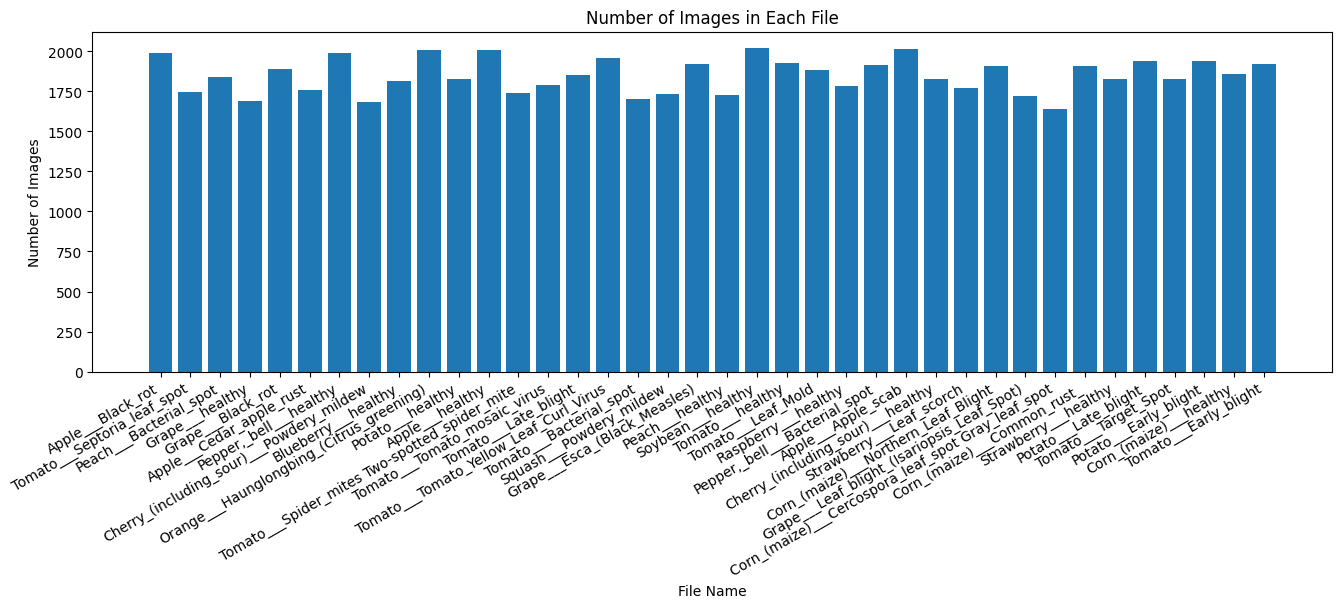

In [ ]:
# prompt: create a histogram for number of images in each file

import matplotlib.pyplot as plt

# Create a dictionary to store the number of images in each file
image_counts = {}
print("No. of Categories = ",len(file_names))
print()
for file_name in file_names:
  # Get the number of images in the file
  num_images = len(os.listdir(os.path.join(data_dir, file_name)))
  # Store the number of images in the dictionary
  image_counts[file_name] = num_images

# Create a histogram
fig, ax = plt.subplots(figsize=(16, 5))
fig.autofmt_xdate()
plt.bar(image_counts.keys(), image_counts.values())
plt.xlabel("File Name")
plt.ylabel("Number of Images")
plt.title("Number of Images in Each File")
plt.show()


In [ ]:
import keras

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    data_dir ,
    image_size=(224,224),
    batch_size=32,
    seed = 123,
    validation_split=.2,
    subset='both'
)

Found 70295 files belonging to 38 classes.
Using 56236 files for training.
Using 14059 files for validation.


In [ ]:
from keras.applications import ResNet50

# Load pre-trained ResNet-50 model without the top (fully connected) layers
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the weights of the pre-trained ResNet-50 layers
for layer in resnet_base.layers:
    layer.trainable = True

# Create the rest of your model
model = keras.Sequential([
    keras.layers.Rescaling(scale=1/255, input_shape=(224, 224, 3)),

    resnet_base,

    keras.layers.GlobalAveragePooling2D(),

    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),

    keras.layers.Dense(38, activation='sigmoid')
])

model.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                         

In [ ]:
import tensorflow
initial_learning_rate = 0.001
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9
)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can use other metrics like 'val_accuracy'
    patience=5,          # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore the best model weights when early stopping
)

In [ ]:
history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=[early_stopping])

Epoch 1/50
1758/1758 [==============================] - 645s 343ms/step - loss: 2.1655 - accuracy: 0.4094 - val_loss: 1.6350 - val_accuracy: 0.5111
Epoch 2/50
1758/1758 [==============================] - 603s 343ms/step - loss: 0.6101 - accuracy: 0.8272 - val_loss: 1.1823 - val_accuracy: 0.7129
Epoch 3/50
1731/1758 [============================>.] - ETA: 8s - loss: 0.3077 - accuracy: 0.9157